### Identifying Bad EEGs

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import fastparquet, pyarrow
from sklearn.preprocessing import StandardScaler

In [8]:
df = pd.read_csv('working_data.csv')

##### Split Data by Activity Type

In [9]:
def activity_df(activity):
    return pd.DataFrame(df[df['expert_consensus'] == activity]).reset_index().drop(columns = 'index')

seizure_df = activity_df('Seizure')
lpd_df = activity_df('LPD')
gpd_df = activity_df('GPD')
lrda_df = activity_df('LRDA')
grda_df = activity_df('GRDA')
other_df = activity_df('Other')

##### Scale Sub EEGs

In [10]:
def scale(df, row):
    eeg = pd.read_parquet('train_eegs/{}.parquet'.format(df['eeg_id'][row]), engine = 'pyarrow')
    first_row = int(df['eeg_label_offset_seconds'][row] * 200)
    last_row = int(first_row + 10000)
    sub_eeg = eeg[first_row: last_row]
    electrodes = sub_eeg.columns
    scaler = StandardScaler()
    sub_eeg = scaler.fit_transform(sub_eeg)
    sub_eeg = pd.DataFrame(sub_eeg, columns = electrodes)
    return sub_eeg

##### Identify Bad EEGs  
  
The goal is to identify EEGs which have, relative to their own distribution, extreme values for every entry. The resulting signal plots of these EEGs are blue from end to end. The method for identifying them is binning values low/middle/high and then using the percentage of values in the low and high bins.

In [11]:
def get_bin_ratios(sub_eeg, electrode):
    total = sub_eeg.shape[0]
    maximum = sub_eeg[electrode].max()
    minimum = sub_eeg[electrode].min()
    step_size = (maximum - minimum) / 4
    boundary1 = minimum + step_size
    boundary3 = boundary1 + (step_size * 2)
    b1, b2, b3 = [], [], []
    for i in range(sub_eeg.shape[0]):
        if sub_eeg[electrode][i] <= boundary1:
            b1.append(sub_eeg[electrode][i])
        elif sub_eeg[electrode][i] > boundary1 and sub_eeg[electrode][i] <= boundary3:
            b2.append(sub_eeg[electrode][i])
        else:
            b3.append(sub_eeg[electrode][i])
    b1_ratio = len(b1) / total
    b2_ratio = len(b2) / total
    b3_ratio = len(b3) / total
    return b1_ratio, b2_ratio, b3_ratio

In [7]:
indexes = [i for i in range(df.shape[0])]
random_indexes = np.random.choice(indexes, size = 500, replace = False)

In [8]:
high_low_ratios = []
for i in random_indexes:
    low, middle, high = get_bin_ratios(scale(df, i), 'Fp1')
    high_low_ratios.append(low + high)

In [9]:
high_low_df = pd.DataFrame([random_indexes, np.asarray(high_low_ratios)], index = ['original_index', 'ratio']).transpose()

In [10]:
to_check = high_low_df[high_low_df['ratio'] > 0.8]['original_index']

In [11]:
to_check = to_check.reset_index().drop(columns = 'index')

In [13]:
to_check

,original_index
0,75896.0
1,64108.0
2,44880.0
3,61726.0
4,60382.0
5,74287.0
6,62801.0


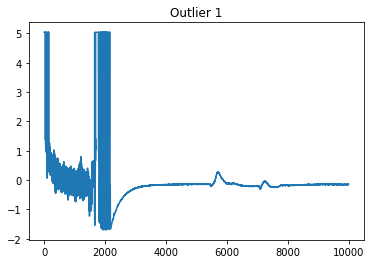

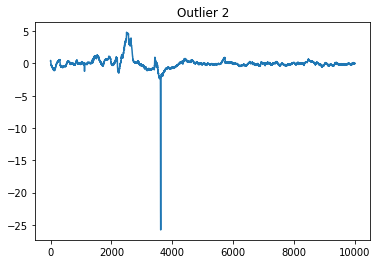

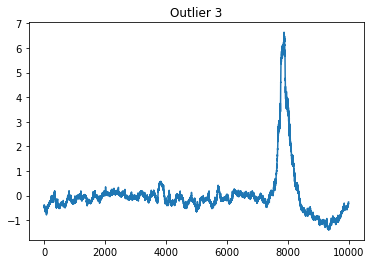

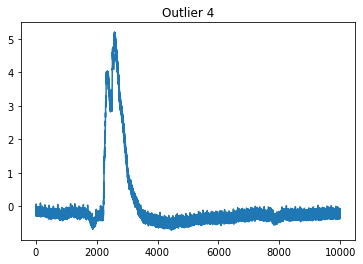

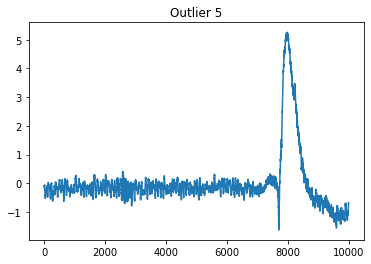

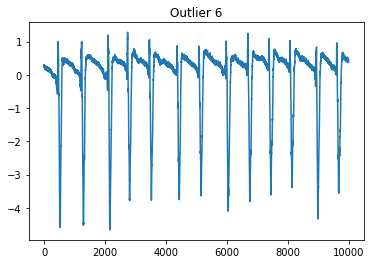

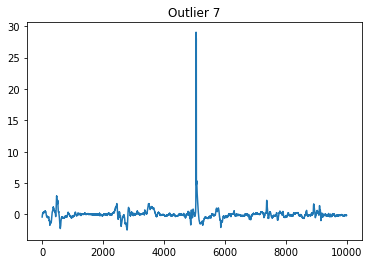

In [14]:
for i in range(len(to_check)):
    sub_eeg = scale(df, to_check['original_index'][i])
    plt.plot(sub_eeg['Fp1'])
    plt.title('Outlier {}'.format(i + 1))
    plt.show()

In [12]:
original_df = pd.read_csv('train.csv')

In [13]:
odf = original_df[original_df['expert_consensus'] == 'Other']
odf = odf.reset_index().drop(columns = 'index')

In [22]:
example = scale(odf, 17634)

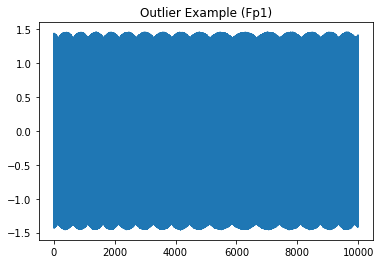

In [23]:
plt.plot(example['Fp1'])
plt.title('Outlier Example (Fp1)')
plt.show()

The below distribution isn't what I expected for the main example I was using as an EEG requiring removal. Apparently, only 63% of its values in the 'Fp1' electrode columns fall within the high and low bins despite the signal plot shown above.

In [24]:
get_bin_ratios(example, 'Fp1')

(0.3179, 0.3644, 0.3177)

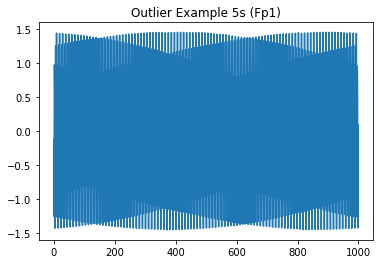

In [25]:
plt.plot(example['Fp1'][0:1000])
plt.title('Outlier Example 5s (Fp1)')
plt.show()

##### Descriptive Statistics by Activity Type